In [208]:
import pandas as pd
import numpy as np
from matplotlib.ticker import PercentFormatter
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDClassifier
from sklearn.utils import compute_class_weight, resample
from sklearn.metrics import confusion_matrix
from seaborn import heatmap
from tqdm import tqdm_notebook as tqdm
import scipy
%matplotlib inline

## Load Patient Data

In [184]:
hr_all = pd.read_csv("../data/alpaca_hr.csv")
resp_all = pd.read_csv("../data/alpaca_resp.csv")
sao2_all = pd.read_csv("../data/alpaca_sao2.csv")
gcs_all = pd.read_csv("../data/patient_motor.csv")

hr_all['offset'] /= 60
resp_all['offset'] /= 60
sao2_all['offset'] /= 60
gcs_all['observationoffset'] /= 60

# calculate length of stay in hrs for each patient (use hr df as patient reference)
max_stays = hr_all.groupby('patientunitstayid').apply(lambda x: x['offset'].max()).values
max_stays = max_stays[max_stays < 720]

#### Bin Data

In [185]:
# set interval in hrs
binning_interval = 1

In [186]:
# assign bins
hr_all['offset_bin'] = hr_all['offset'] // binning_interval
resp_all['offset_bin'] = resp_all['offset'] // binning_interval
sao2_all['offset_bin'] = sao2_all['offset'] // binning_interval
gcs_all['offset_bin'] = gcs_all['observationoffset'] // binning_interval

# calculate bin mean for each patient
hr_binned = hr_all.drop(columns='offset').groupby(['patientunitstayid', 'offset_bin']).mean().reset_index()
resp_binned = resp_all.drop(columns='offset').groupby(['patientunitstayid', 'offset_bin']).mean().reset_index()
sao2_binned = sao2_all.drop(columns='offset').groupby(['patientunitstayid', 'offset_bin']).mean().reset_index()
gcs_x = gcs_all.drop(columns='observationoffset').groupby(['patientunitstayid', 'offset_bin']).mean().reset_index()

# aggregate latest gcs score as the label
gcs_y = gcs_all.groupby(['patientunitstayid', 'offset_bin']).agg(lambda x: x.iloc[-1]).reset_index().rename(columns={'Value': 'gcs_label'})[['patientunitstayid', 'offset_bin', 'gcs_label']]

# merge the x and y gcs dataframes into gcs_binned
gcs_binned = gcs_x.merge(gcs_y, how='left')

# calculate the maximum number of bins (for reindexing)
max_bins = max_stays.max() // binning_interval + 1

# reindex helper method
def rein(df):
    return df.set_index('offset_bin').reindex(np.arange(max_bins))

# reindex hr df, use this as merging table for other values
hr_binned = hr_binned.groupby('patientunitstayid').apply(rein).drop(columns='patientunitstayid').reset_index()

# format column names to allow merging
hr_binned.rename(columns={'value' : 'hr'}, inplace=True)
resp_binned.rename(columns={'value' : 'resp'}, inplace=True)
sao2_binned.rename(columns={'value' : 'sao2'}, inplace=True)
gcs_binned.rename(columns={'Value' : 'gcs'}, inplace=True)

# merge data
ts_binned = hr_binned.merge(resp_binned, how='left').merge(sao2_binned, how='left').merge(gcs_binned, how='left')
ts_binned = ts_binned.groupby('patientunitstayid').apply(lambda x: x.fillna(method='bfill')).dropna()

# require patients to have data for at least 12 hrs
patient_data_lens = pd.DataFrame(ts_binned.groupby('patientunitstayid').agg('max')['offset_bin']).reset_index()
patient_data_lens = patient_data_lens[patient_data_lens['offset_bin'] >= 12][['patientunitstayid']]

# merge patient list into ts_binned
ts_binned = patient_data_lens.merge(ts_binned)

# display data
display(ts_binned)

print('Number of Patients:', len(ts_binned.groupby('patientunitstayid').agg('max')['offset_bin']))

,patientunitstayid,offset_bin,hr,resp,sao2,gcs,gcs_label
0,242714,0.0,102.181818,37.875000,94.545455,6.0,6.0
1,242714,1.0,105.583333,37.875000,93.916667,6.0,6.0
2,242714,2.0,102.166667,37.875000,94.083333,6.0,6.0
3,242714,3.0,100.000000,37.875000,94.583333,6.0,6.0
4,242714,4.0,101.166667,37.875000,93.583333,6.0,6.0
...,...,...,...,...,...,...,...
210768,3352819,13.0,81.416667,31.000000,98.750000,6.0,6.0
210769,3352819,14.0,81.666667,30.916667,97.616667,6.0,6.0
210770,3352819,15.0,86.333333,27.583333,97.175000,6.0,6.0
210771,3352819,16.0,80.166667,30.916667,97.833333,6.0,6.0


Number of Patients: 2064


#### Format data, create X and y for training

In [187]:
# set prediction window, memory window
prediction_window = 6
memory_window = 12

In [230]:
# split train/test
train_patients, test_patients = train_test_split(patients[['patientunitstayid']], test_size=0.2)
ts_binned_train = train_patients.merge(ts_binned)
ts_binned_test = test_patients.merge(ts_binned)

# separate patient data into array of samples - train
grouped_data_train = [g.drop(columns=['patientunitstayid', 'offset_bin']).values for _, g in ts_binned_train.groupby('patientunitstayid')]

train_X = []
train_y = []
for arr in grouped_data_train:
    for i in range(0, arr.shape[0] - prediction_window - memory_window + 1):
        train_X.append(arr[i:i + memory_window, :-1].flatten('F'))
        train_y.append(arr[i + memory_window + prediction_window - 1, -1])

train_X = np.vstack(train_X)
train_y = np.vstack(train_y).flatten()

# separate patient data into array of samples - test
grouped_data_test = [g.drop(columns=['patientunitstayid', 'offset_bin']).values for _, g in ts_binned_test.groupby('patientunitstayid')]
    
test_X = []
test_y = []
for arr in grouped_data_test:
    for i in range(0, arr.shape[0] - prediction_window - memory_window + 1):
        test_X.append(arr[i:i + memory_window, :-1].flatten('F'))
        test_y.append(arr[i + memory_window + prediction_window - 1, -1])

test_X = np.vstack(test_X)
test_y = np.vstack(test_y).flatten()

# resample to achieve class balance (oversample underrepresented classes)
# so that we don't oversample excessively, get the average number of samples per class and use that number

# training data resample
num_samples_train = int(np.unique(train_y, return_counts=True)[1].mean())
resampled_train_X = []
resampled_train_y = []
for i in range(1, 7):
    samples_i = np.hstack([train_X[train_y == i], train_y[train_y == i].reshape(-1, 1)])
    samples_i = resample(samples_i, replace=True, n_samples=num_samples_train)
    resampled_train_X.append(samples_i[:, :-1])
    resampled_train_y.append(samples_i[:, -1].reshape(-1, 1))
    
train_X = np.vstack(resampled_train_X)
train_y = np.vstack(resampled_train_y)

# testing data resample
num_samples_test = int(np.unique(test_y, return_counts=True)[1].mean())
resampled_test_X = []
resampled_test_y = []
for i in range(1, 7):
    samples_i = np.hstack([test_X[test_y == i], test_y[test_y == i].reshape(-1, 1)])
    samples_i = resample(samples_i, replace=True, n_samples=num_samples_test)
    resampled_test_X.append(samples_i[:, :-1])
    resampled_test_y.append(samples_i[:, -1].reshape(-1, 1))
    
test_X = np.vstack(resampled_test_X)
test_y = np.vstack(resampled_test_y)

# scale data (to be applied when initializing dataset)
scaler = StandardScaler()
train_X = scaler.fit_transform(train_X)
test_X = scaler.transform(test_X)

# apply PCA (use 5 components like in Aim 1)
n = 5
hr_pca = PCA(n_components=n)
resp_pca = PCA(n_components=n)
sao2_pca = PCA(n_components=n)
gcs_pca = PCA(n_components=n)

# split train into components
train_hr = train_X[:, :memory_window]
train_resp = train_X[:, memory_window:2 * memory_window]
train_sao2 = train_X[:, 2 * memory_window:3 * memory_window]
train_gcs = train_X[:, 3 * memory_window:4 * memory_window]

# split test into components
test_hr = test_X[:, :memory_window]
test_resp = test_X[:, memory_window:2 * memory_window]
test_sao2 = test_X[:, 2 * memory_window:3 * memory_window]
test_gcs = test_X[:, 3 * memory_window:4 * memory_window]

# fit/transform train
train_hr = hr_pca.fit_transform(train_hr)
train_resp = resp_pca.fit_transform(train_resp)
train_sao2 = sao2_pca.fit_transform(train_sao2)
train_gcs = gcs_pca.fit_transform(train_gcs)
train_X_pca = np.hstack([train_hr, train_resp, train_sao2, train_gcs])

# transform test
test_hr = hr_pca.transform(test_hr)
test_resp = resp_pca.transform(test_resp)
test_sao2 = sao2_pca.transform(test_sao2)
test_gcs = gcs_pca.transform(test_gcs)
test_X_pca = np.hstack([test_hr, test_resp, test_sao2, test_gcs])

## Model Training/Evaluation

/home/adit/.virtualenvs/pcm/lib/python3.6/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Training Accuracy: 0.6413878562577447
Testing Accuracy: 0.6065857377433732


Text(33.0, 0.5, 'Actual')

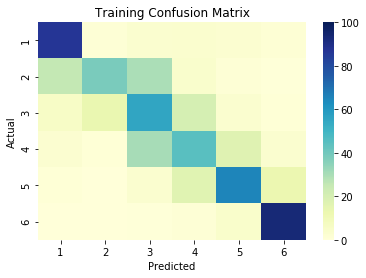

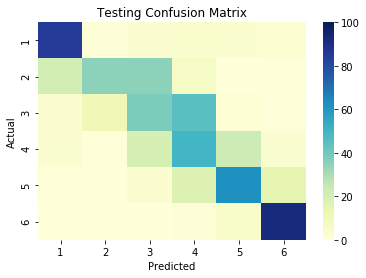

In [232]:
# check if we want PCA
use_pca = True
if use_pca:
    train_X = train_X_pca
    test_X = test_X_pca

# create model
clf = SGDClassifier(loss='log', penalty='elasticnet')

# fit model
clf.fit(train_X, train_y)

# get training score
print("Training Accuracy:", clf.score(train_X, train_y))

# display training heatmap
train_preds = clf.predict(train_X)
train_conf_mat = confusion_matrix(train_y, train_preds)

plt.figure()
plt.title("Training Confusion Matrix")
heatmap(100 * train_conf_mat / np.sum(train_conf_mat, axis=1), xticklabels=np.arange(1, 7), yticklabels=np.arange(1, 7), vmin=0, vmax=100, cmap="YlGnBu")
plt.xlabel("Predicted")
plt.ylabel("Actual")

# get testing score
print("Testing Accuracy:", clf.score(test_X, test_y))

# display testing heatmap
test_preds = clf.predict(test_X)
test_conf_mat = confusion_matrix(test_y, test_preds)

plt.figure()
plt.title("Testing Confusion Matrix")
heatmap(100 * test_conf_mat / np.sum(test_conf_mat, axis=1), xticklabels=np.arange(1, 7), yticklabels=np.arange(1, 7), vmin=0, vmax=100, cmap="YlGnBu")
plt.xlabel("Predicted")
plt.ylabel("Actual")

Training Accuracy: 78.24691582828788
Testing Accuracy: 76.64057030106295


Text(33.0, 0.5, 'Actual')

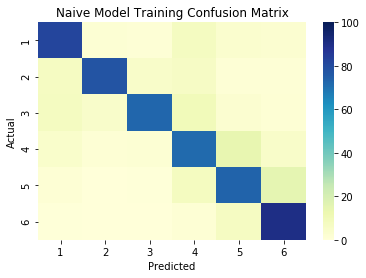

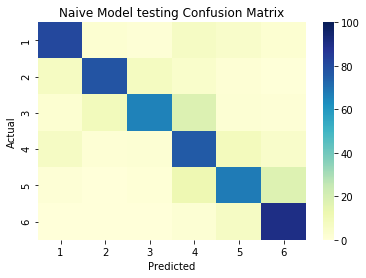

In [228]:
# now get the naive classifier's heatmap (predict mode gcs as gcs (no change basically))

# training heatmap
naive_pred_y_train = scipy.stats.mode(scaler.inverse_transform(train_X)[:, -12:], axis=1).mode.astype(int)
print("Training Accuracy:", 100 * np.mean(naive_pred_y_train == train_y))
naive_conf_mat_train = confusion_matrix(train_y, naive_pred_y_train)

plt.figure()
plt.title("Naive Model Training Confusion Matrix")
heatmap(100 * naive_conf_mat_train / np.sum(naive_conf_mat_train, axis=1), xticklabels=np.arange(1, 7), yticklabels=np.arange(1, 7), vmin=0, vmax=100, cmap="YlGnBu")
plt.xlabel("Predicted")
plt.ylabel("Actual")

# testing heatmap
naive_pred_y_test = scipy.stats.mode(scaler.inverse_transform(test_X)[:, -12:], axis=1).mode.astype(int)
print("Testing Accuracy:", 100 * np.mean(naive_pred_y_test == test_y))
naive_conf_mat_test = confusion_matrix(test_y, naive_pred_y_test)

plt.figure()
plt.title("Naive Model testing Confusion Matrix")
heatmap(100 * naive_conf_mat_test / np.sum(naive_conf_mat_test, axis=1), xticklabels=np.arange(1, 7), yticklabels=np.arange(1, 7), vmin=0, vmax=100, cmap="YlGnBu")
plt.xlabel("Predicted")
plt.ylabel("Actual")